In [1]:
! pip install keras-nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.1/644.1 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 24.0 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('en-fr.txt',names=['en','fr','attr'],usecols=['en','fr'],sep='\t')
data = data.sample(frac=1,random_state=42)
data = data.reset_index(drop=True)

In [4]:
data

,en,fr
0,You're very clever.,Vous êtes fort ingénieuse.
1,Are there kids?,Y a-t-il des enfants ?
2,Come in.,Entrez !
3,Where's Boston?,Où est Boston ?
4,You see what I mean?,Vous voyez ce que je veux dire ?
...,...,...
49995,My plan worked.,Mon plan a fonctionné.
49996,Tom accepted the job.,Tom accepta le travail.
49997,Tom is proud of you.,Tom est fier de toi.
49998,Can we go?,Pouvons-nous nous en aller ?


In [5]:
def remove_punctuation(text):
    punc = '''@#$%^&*()_+{}[]<>:;,.~!/|\t\n?-~=`'''

    without_punc = ''
    temp = []
    for char in text:
        if char not in punc:
            temp.append(char)

    without_punc = without_punc + ''.join(c for c in temp)

    return without_punc

In [6]:
def put_token(text):
    text = remove_punctuation(text)

    new_text = '<start> ' + text + ' <end>'

    return new_text

In [7]:
t = 'hello@ how there i-s where*&'
put_token(t)

'<start> hello how there is where <end>'

In [8]:
data['en'] = data['en'].apply(lambda row:remove_punctuation(row))
data['fr'] = data['fr'].apply(lambda row:put_token(row))

In [9]:
data

,en,fr
0,You're very clever,<start> Vous êtes fort ingénieuse <end>
1,Are there kids,<start> Y atil des enfants <end>
2,Come in,<start> Entrez <end>
3,Where's Boston,<start> Où est Boston <end>
4,You see what I mean,<start> Vous voyez ce que je veux dire <end>
...,...,...
49995,My plan worked,<start> Mon plan a fonctionné <end>
49996,Tom accepted the job,<start> Tom accepta le travail <end>
49997,Tom is proud of you,<start> Tom est fier de toi <end>
49998,Can we go,<start> Pouvonsnous nous en aller <end>


In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(data['en'])

In [12]:
english = en_tokenizer.texts_to_sequences(data['en'])

In [ ]:
english

In [14]:
fr_tokenizer = Tokenizer(filters='@#$%^&*()_+{}[]!/|\t\n?-~=:;.,')
fr_tokenizer.fit_on_texts(data['fr'])

In [15]:
french = fr_tokenizer.texts_to_sequences(data['fr'])

In [ ]:
french

In [17]:
eng_len = max([len(seq) for seq in english])
fr_len = max([len(seq) for seq in french])

max_len = max(eng_len,fr_len)

In [18]:
max_len

16

In [19]:
english_padded = pad_sequences(english,maxlen=max_len,padding='post')

In [20]:
english_padded.shape

(50000, 16)

In [21]:
french_padded = pad_sequences(french,maxlen=max_len+1,padding='post')

In [22]:
english_padded[0]

array([ 15,  37, 566,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

In [23]:
french_padded[1]

array([  1,  49, 164,  37, 282,   2,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)

In [24]:
english_padded[0]

array([ 15,  37, 566,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

In [25]:
input_ = {'encoder_input':english_padded,'decoder_input':french_padded[:,:-1]}
output = french_padded[:,1:]

In [26]:
english_vocab_size = len(en_tokenizer.word_index) + 1
french_vocab_size = len(fr_tokenizer.word_index) + 1

In [27]:
english_vocab_size

6115

In [28]:
french_vocab_size

14095

In [29]:
import tensorflow
from tensorflow.keras.layers import Dense,Input,Dropout,Masking,Embedding,Layer
from tensorflow.keras.models import Model,load_model
from keras_nlp.layers import TokenAndPositionEmbedding,TransformerEncoder,TransformerDecoder

In [30]:
heads = 8
embedding_dimension = 512

In [61]:
import keras

@keras.saving.register_keras_serializable()
def masked_loss(true,pred):
  mask = tensorflow.not_equal(true,0)

  loss = tensorflow.keras.losses.sparse_categorical_crossentropy(true,pred)

  mask = tensorflow.cast(mask,dtype=loss.dtype)

  loss = loss*mask

  return tensorflow.reduce_sum(loss)/tensorflow.reduce_sum(mask)

*Masked Tokenizer*

***Encoder***

In [31]:
encoder_input = Input(shape=(None,),dtype='int64',name='encoder_input')
embeddings = TokenAndPositionEmbedding(vocabulary_size=english_vocab_size,sequence_length=max_len,embedding_dim=embedding_dimension)(encoder_input)
encoder_output = TransformerEncoder(intermediate_dim=embedding_dimension,num_heads=heads)(embeddings)

encoded_seq_input = Input(shape=(None,embedding_dimension))

***Decoder***

In [32]:
decoder_input = Input(shape=(None,),dtype='int64',name='decoder_input')
x = TokenAndPositionEmbedding(vocabulary_size=french_vocab_size,sequence_length=max_len,embedding_dim=embedding_dimension,mask_zero=True)(decoder_input)
x = TransformerDecoder(embedding_dimension,heads)(x,encoded_seq_input)
x = Dropout(0.1)(x)
decoder_output = Dense(french_vocab_size,activation='softmax')(x)

# seperate model for decoder
decoder = Model([decoder_input,encoded_seq_input],decoder_output)
decoder_output = decoder([decoder_input,encoder_output])

***transformer as model***

In [33]:
model = Model([encoder_input,decoder_input],decoder_output)

In [35]:
model.compile(optimizer='adam',loss=masked_loss,metrics=['accuracy'])

In [36]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 512)      │      3,139,072 │ encoder_input[0][0]    │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_input             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, None, 512)      │      1,577,984 │ token_and_position_em… │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, None, 14095)    │     17,085,199 │ decoder_input[0][0],   │
│                           │                        │                │ transformer_encoder[0… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 21,802,255 (83.17 MB)

 Trainable params: 21,802,255 (83.17 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model.keras',monitor='val_loss',save_best_only=True)

In [39]:
import warnings
warnings.filterwarnings('ignore')

In [63]:
fitted_model = model.fit(input_,output,epochs=5,validation_split=0.1,callbacks=[checkpoint])

Epoch 1/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 58s 41ms/step - accuracy: 0.3048 - loss: 0.1002 - val_accuracy: 0.2828 - val_loss: 0.9655
Epoch 2/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - accuracy: 0.3035 - loss: 0.1068 - val_accuracy: 0.2834 - val_loss: 0.9635
Epoch 3/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.3063 - loss: 0.0823 - val_accuracy: 0.2832 - val_loss: 0.9581
Epoch 4/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.3011 - loss: 0.1552 - val_accuracy: 0.2784 - val_loss: 1.0100
Epoch 5/5
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 70s 50ms/step - accuracy: 0.3023 - loss: 0.1207 - val_accuracy: 0.2835 - val_loss: 0.9385


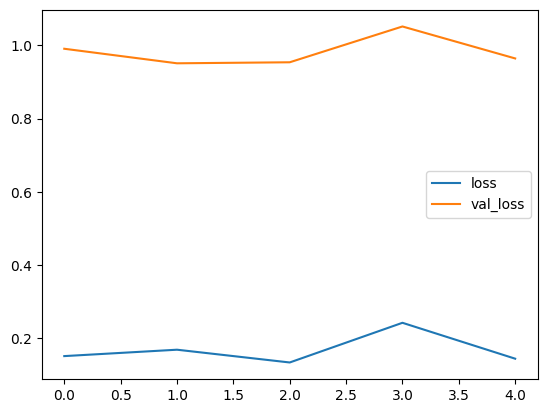

In [45]:
plt.plot(fitted_model.history['loss'],label='loss')
plt.plot(fitted_model.history['val_loss'],label='val_loss')
plt.legend()

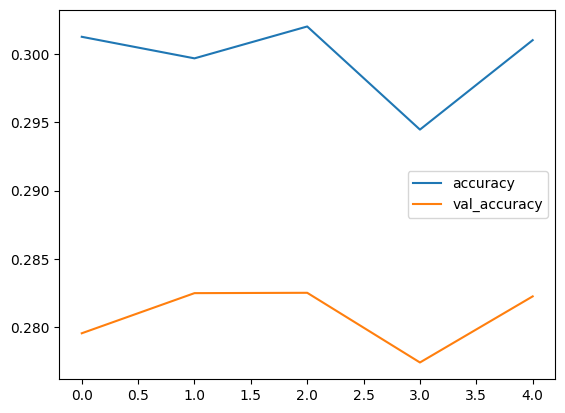

In [46]:
plt.plot(fitted_model.history['accuracy'],label='accuracy')
plt.plot(fitted_model.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [67]:
model.save('model.keras')

In [64]:
best_model = load_model('best_model.keras')

In [48]:
def translate_text(text, model, en_tokenizer, fr_tokenizer, fr_index_lookup, sequence_len):
    input_sequence = en_tokenizer.texts_to_sequences([text])
    padded_input_sequence = pad_sequences(input_sequence, maxlen=sequence_len, padding='post')
    decoded_text = '<start>'

    for i in range(sequence_len):
        target_sequence = fr_tokenizer.texts_to_sequences([decoded_text])
        padded_target_sequence = pad_sequences(target_sequence, maxlen=sequence_len, padding='post')[:, :-1]

        prediction = model([padded_input_sequence, padded_target_sequence])

        idx = np.argmax(prediction[0, i, :])
        token = fr_index_lookup[idx]
        decoded_text += ' ' + token

        if token == '<end>':
            break

    return decoded_text

In [49]:
fr_vocab = fr_tokenizer.word_index
fr_index_lookup = fr_tokenizer.index_word
# fr_index_lookup = dict(zip(range(len(fr_vocab)), fr_vocab))

In [55]:
data

,en,fr
0,You're very clever,<start> Vous êtes fort ingénieuse <end>
1,Are there kids,<start> Y atil des enfants <end>
2,Come in,<start> Entrez <end>
3,Where's Boston,<start> Où est Boston <end>
4,You see what I mean,<start> Vous voyez ce que je veux dire <end>
...,...,...
49995,My plan worked,<start> Mon plan a fonctionné <end>
49996,Tom accepted the job,<start> Tom accepta le travail <end>
49997,Tom is proud of you,<start> Tom est fier de toi <end>
49998,Can we go,<start> Pouvonsnous nous en aller <end>


In [66]:
text = "sorry"

translate_text(text, best_model, en_tokenizer, fr_tokenizer, fr_index_lookup, max_len)

"<start> j'essayai cellesci <end>"